In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import shutil
import random
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load CSV file containing image IDs and labels
csv_file_id = "1NH-jvwPFytwAJSL_uhlMDLwBI5PHRvJW"
csv_file = drive.CreateFile({'id': csv_file_id})
csv_file.GetContentFile("ISIC-2017_Training_Part3_GroundTruth.csv")

# Load ZIP file containing images
zip_file_id = "1pWLAcNGTcJf8rLp2RIs5BSBvLZovFiCd"
zip_file = drive.CreateFile({'id': zip_file_id})
zip_file.GetContentFile("ISIC-2017_Training_Data.zip")

# Unzip the image data
with zipfile.ZipFile("ISIC-2017_Training_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("extracted_images")

# Preprocess images and create dataset
image_dir = "extracted_images/ISIC-2017_Training_Data"  # Adjusted directory path

# Load CSV file containing image IDs and labels
df = pd.read_csv("ISIC-2017_Training_Part3_GroundTruth.csv")

# Create new directories for melanoma and non-melanoma images
melanoma_dir = "melanoma_images"
non_melanoma_dir = "non_melanoma_images"

os.makedirs(melanoma_dir, exist_ok=True)
os.makedirs(non_melanoma_dir, exist_ok=True)

# Segregate images based on melanoma label
for index, row in df.iterrows():
    img_id = row['image_id']
    img_path = os.path.join(image_dir, img_id + ".jpg")

    # Check if the image file exists
    if not os.path.exists(img_path):
        print("Image file not found:", img_path)
        continue

    # Determine the directory based on the 'melanoma' column
    if row['melanoma'] == 1:
        destination_dir = melanoma_dir
    else:
        destination_dir = non_melanoma_dir

    # Move the image file to the corresponding directory
    shutil.copy(img_path, destination_dir)

print("Images preprocessed successfully.")




Images preprocessed successfully.


In [2]:
num_melanoma_images = len(os.listdir(melanoma_dir))
num_non_melanoma_images = len(os.listdir(non_melanoma_dir))


# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Determine which class has fewer images
if num_non_melanoma_images < num_melanoma_images:
    class_to_augment = non_melanoma_dir
    class_to_balance = melanoma_dir
    augmentation_factor = num_melanoma_images // num_non_melanoma_images
else:
    class_to_augment = melanoma_dir
    class_to_balance = non_melanoma_dir
    augmentation_factor = num_non_melanoma_images // num_melanoma_images

# Perform augmentation for the class with fewer images
class_images = os.listdir(class_to_augment)
for img_file in class_images:
    img_path = os.path.join(class_to_augment, img_file)
    img = Image.open(img_path)
    img = img.convert("RGB")
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Generate augmented images with a limit
    num_augmented_images = 0
    for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_to_augment, save_prefix='aug', save_format='jpeg'):
        num_augmented_images += 1
        if num_augmented_images >= augmentation_factor:
            break

print("Images augmented successfully.")







Images augmented successfully.


In [3]:
# List images in melanoma_images directory
print("Images in melanoma_images directory:")
melanoma_images = os.listdir(melanoma_dir)
print(melanoma_images)

# List images in non_melanoma_images directory
print("\nImages in non_melanoma_images directory:")
non_melanoma_images = os.listdir(non_melanoma_dir)
print(non_melanoma_images)

Images in melanoma_images directory:
['aug_0_3080.jpeg', 'aug_0_5421.jpeg', 'aug_0_425.jpeg', 'aug_0_3662.jpeg', 'aug_0_1645.jpeg', 'ISIC_0000522.jpg', 'aug_0_2717.jpeg', 'aug_0_3294.jpeg', 'aug_0_401.jpeg', 'aug_0_994.jpeg', 'ISIC_0000077.jpg', 'ISIC_0014187.jpg', 'aug_0_1662.jpeg', 'ISIC_0000552.jpg', 'aug_0_8316.jpeg', 'aug_0_7264.jpeg', 'ISIC_0013671.jpg', 'aug_0_9608.jpeg', 'aug_0_8789.jpeg', 'aug_0_3393.jpeg', 'aug_0_7975.jpeg', 'aug_0_3903.jpeg', 'aug_0_4282.jpeg', 'aug_0_7755.jpeg', 'aug_0_1569.jpeg', 'aug_0_8186.jpeg', 'aug_0_4962.jpeg', 'aug_0_9222.jpeg', 'ISIC_0011140.jpg', 'aug_0_5621.jpeg', 'ISIC_0010225.jpg', 'aug_0_5.jpeg', 'aug_0_8568.jpeg', 'aug_0_435.jpeg', 'aug_0_6684.jpeg', 'aug_0_2354.jpeg', 'aug_0_516.jpeg', 'aug_0_1107.jpeg', 'aug_0_3308.jpeg', 'aug_0_1090.jpeg', 'aug_0_2659.jpeg', 'aug_0_9791.jpeg', 'aug_0_6612.jpeg', 'ISIC_0011121.jpg', 'aug_0_4094.jpeg', 'aug_0_3016.jpeg', 'aug_0_6894.jpeg', 'aug_0_7842.jpeg', 'aug_0_7092.jpeg', 'ISIC_0000150.jpg', 'ISIC_00001

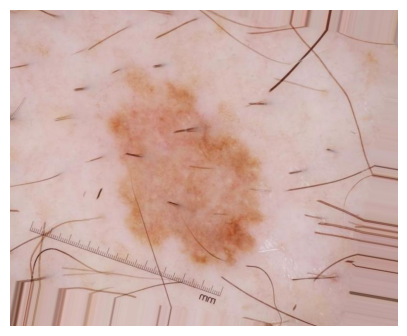

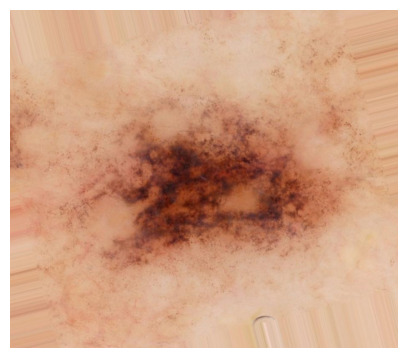

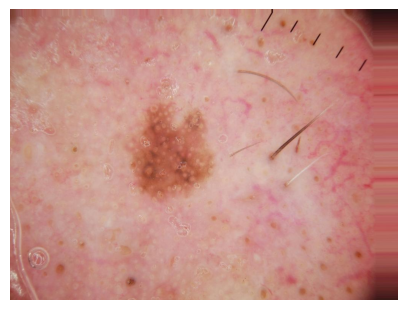

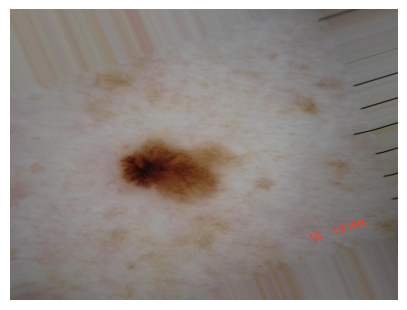

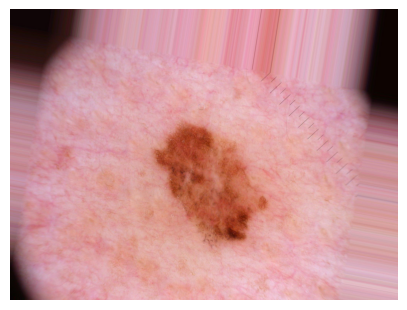

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the directory containing melanoma images
melanoma_dir = "melanoma_images"

# Get list of image files in the directory
image_files = os.listdir(melanoma_dir)

# Display the first 5 images
num_images_to_display = 5
for i in range(num_images_to_display):
    img_path = os.path.join(melanoma_dir, image_files[i])
    img = mpimg.imread(img_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [5]:
import os
import shutil
import random

# Define source directories
source_melanoma = 'melanoma_images'
source_non_melanoma = 'non_melanoma_images'

# Define target directories
train_melanoma_dir = 'train_melanoma'
validation_melanoma_dir = 'validation_melanoma'
test_melanoma_dir = 'test_melanoma'

train_non_melanoma_dir = 'train_non_melanoma'
validation_non_melanoma_dir = 'validation_non_melanoma'
test_non_melanoma_dir = 'test_non_melanoma'

# Create target directories
os.makedirs(train_melanoma_dir, exist_ok=True)
os.makedirs(validation_melanoma_dir, exist_ok=True)
os.makedirs(test_melanoma_dir, exist_ok=True)

os.makedirs(train_non_melanoma_dir, exist_ok=True)
os.makedirs(validation_non_melanoma_dir, exist_ok=True)
os.makedirs(test_non_melanoma_dir, exist_ok=True)

# Function to split images
def split_data(source, train, validation, test, split_ratio=(0.6, 0.2, 0.2)):
    files = os.listdir(source)
    random.shuffle(files)
    total_files = len(files)
    train_split = int(total_files * split_ratio[0])
    validation_split = int(total_files * (split_ratio[0] + split_ratio[1]))

    train_files = files[:train_split]
    validation_files = files[train_split:validation_split]
    test_files = files[validation_split:]

    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train, file))

    for file in validation_files:
        shutil.copy(os.path.join(source, file), os.path.join(validation, file))

    for file in test_files:
        shutil.copy(os.path.join(source, file), os.path.join(test, file))

# Split melanoma images
split_data(source_melanoma, train_melanoma_dir, validation_melanoma_dir, test_melanoma_dir)

# Split non-melanoma images
split_data(source_non_melanoma, train_non_melanoma_dir, validation_non_melanoma_dir, test_non_melanoma_dir)

print("Data split successfully.")

Data split successfully.


In [6]:
import os
import shutil

# Define the mother directory name
mother_directory = 'train_data'


# Create the mother directory if it doesn't exist
if not os.path.exists(mother_directory):
    os.makedirs(mother_directory)

# Move train_melanoma directory into the mother directory
shutil.move('train_melanoma', os.path.join(mother_directory, 'train_melanoma'))

# Move train_non_melanoma directory into the mother directory
shutil.move('train_non_melanoma', os.path.join(mother_directory, 'train_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


In [7]:
import os
import shutil

# Define the mother directory names
mother_validation_directory = 'validation_data'
mother_test_directory = 'test_data'

# Create the mother directories if they don't exist
if not os.path.exists(mother_validation_directory):
    os.makedirs(mother_validation_directory)
if not os.path.exists(mother_test_directory):
    os.makedirs(mother_test_directory)

# Move validation_melanoma directory into the mother validation directory
shutil.move('validation_melanoma', os.path.join(mother_validation_directory, 'validation_melanoma'))

# Move validation_non_melanoma directory into the mother validation directory
shutil.move('validation_non_melanoma', os.path.join(mother_validation_directory, 'validation_non_melanoma'))

# Move test_melanoma directory into the mother test directory
shutil.move('test_melanoma', os.path.join(mother_test_directory, 'test_melanoma'))

# Move test_non_melanoma directory into the mother test directory
shutil.move('test_non_melanoma', os.path.join(mother_test_directory, 'test_non_melanoma'))

print("Directories moved successfully.")

Directories moved successfully.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze some of the base model layers
for layer in base_model.layers[:-100]:  # Unfreeze the last 100 layers
    layer.trainable = False

# Define a custom self-attention layer
class SelfAttention(layers.Layer):
    def _init_(self, **kwargs):
        super(SelfAttention, self)._init_(**kwargs)

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='random_normal', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        query = tf.matmul(inputs, self.Wq)
        key = tf.matmul(inputs, self.Wk)
        value = tf.matmul(inputs, self.Wv)
        score = tf.matmul(query, key, transpose_b=True)
        scaled_score = tf.nn.softmax(score / tf.math.sqrt(tf.cast(tf.shape(key)[-1], tf.float32)))
        attention = tf.matmul(scaled_score, value)
        return attention

# Construct the model with self-attention, batch normalization, and L2 regularization
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    SelfAttention(),  # Add self-attention layer here
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with a lower learning rate and learning rate scheduler
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

Found 2038 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 681 images belonging to 2 classes.
343610240/343610240 [==============================] - 1s 0us/step
Epoch 1/50
64/64 [==============================] - 240s 3s/step - loss: 1.1952 - accuracy: 0.7007 - val_loss: 1.9875 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - 194s 3s/step - loss: 1.0123 - accuracy: 0.7669 - val_loss: 1.4770 - val_accuracy: 0.5368 - lr: 1.0000e-04
Epoch 3/50
64/64 [==============================] - 195s 3s/step - loss: 0.8639 - accuracy: 0.8106 - val_loss: 2.2153 - val_accuracy: 0.5441 - lr: 1.0000e-04
Epoch 4/50
64/64 [==============================] - 195s 3s/step - loss: 0.8040 - accuracy: 0.8459 - val_loss: 2.3811 - val_accuracy: 0.5926 - lr: 1.0000e-04
Epoch 5/50
64/64 [==============================] - 196s 3s/step - loss: 0.7391 - accuracy: 0.8778 - val_loss: 2.4450 - val_accuracy: 0.6868 - lr: 1.0000e-04
Epoch 6/50
64/64 [=

NASNET WITH TWO DENSE LAYERS

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,

      # Added dense layer with 512 units
    layers.Dense(256, activation='relu'),  # Added dense layer with 256 units
    layers.Dense(128, activation='relu'),  # Existing dense layer with 128 units
    layers.Dropout(0.5),  # Single dropout layer
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

Found 2040 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, None, None, 1) vs (None,)).


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Added global average pooling layer
    layers.Dense(256, activation='relu'),  # Added dense layer with 256 units
    layers.Dense(128, activation='relu'),  # Existing dense layer with 128 units
    layers.Dropout(0.5),  # Single dropout layer
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")


Found 2040 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Found 682 images belonging to 2 classes.
Epoch 1/50
64/64 [==============================] - 207s 3s/step - loss: 0.5816 - accuracy: 0.6887 - val_loss: 0.4311 - val_accuracy: 0.7971
Epoch 2/50
64/64 [==============================] - 179s 3s/step - loss: 0.4597 - accuracy: 0.7794 - val_loss: 0.4359 - val_accuracy: 0.7897
Epoch 3/50
64/64 [==============================] - 178s 3s/step - loss: 0.4257 - accuracy: 0.7892 - val_loss: 0.3867 - val_accuracy: 0.8279
Epoch 4/50
64/64 [==============================] - 178s 3s/step - loss: 0.4075 - accuracy: 0.7980 - val_loss: 0.3798 - val_accuracy: 0.8265
Epoch 5/50
64/64 [==============================] - 177s 3s/step - loss: 0.3422 - accuracy: 0.8407 - val_loss: 0.4422 - val_accuracy: 0.7985
Epoch 6/50
64/64 [==============================] - 176s 3s/step - loss: 0.3453 - accuracy: 0.8353 - val_loss: 0.3541 - val_accuracy: 0.8485
Epoch 7/50
64/64 [============

NASNET 3 DENSE LAYERS

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Added dense layer with 512 units
    layers.Dense(256, activation='relu'),  # Added dense layer with 256 units
    layers.Dense(128, activation='relu'),  # Existing dense layer with 128 units
    layers.Dropout(0.5),  # Single dropout layer
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")

Found 2031 images belonging to 2 classes.
Found 677 images belonging to 2 classes.
Found 679 images belonging to 2 classes.
Epoch 1/50
64/64 [==============================] - 210s 3s/step - loss: 0.5774 - accuracy: 0.6893 - val_loss: 0.4215 - val_accuracy: 0.7858
Epoch 2/50
64/64 [==============================] - 185s 3s/step - loss: 0.4833 - accuracy: 0.7592 - val_loss: 0.4218 - val_accuracy: 0.8139
Epoch 3/50
64/64 [==============================] - 182s 3s/step - loss: 0.4423 - accuracy: 0.7893 - val_loss: 0.4706 - val_accuracy: 0.7622
Epoch 4/50
64/64 [==============================] - 184s 3s/step - loss: 0.3752 - accuracy: 0.8154 - val_loss: 0.3777 - val_accuracy: 0.8257
Epoch 5/50
64/64 [==============================] - 182s 3s/step - loss: 0.3566 - accuracy: 0.8282 - val_loss: 0.3596 - val_accuracy: 0.8390
Epoch 6/50
64/64 [==============================] - 183s 3s/step - loss: 0.3354 - accuracy: 0.8439 - val_loss: 0.3848 - val_accuracy: 0.8198
Epoch 7/50
64/64 [============

Confusion Matrix:
[[270  83]
 [ 36 290]]


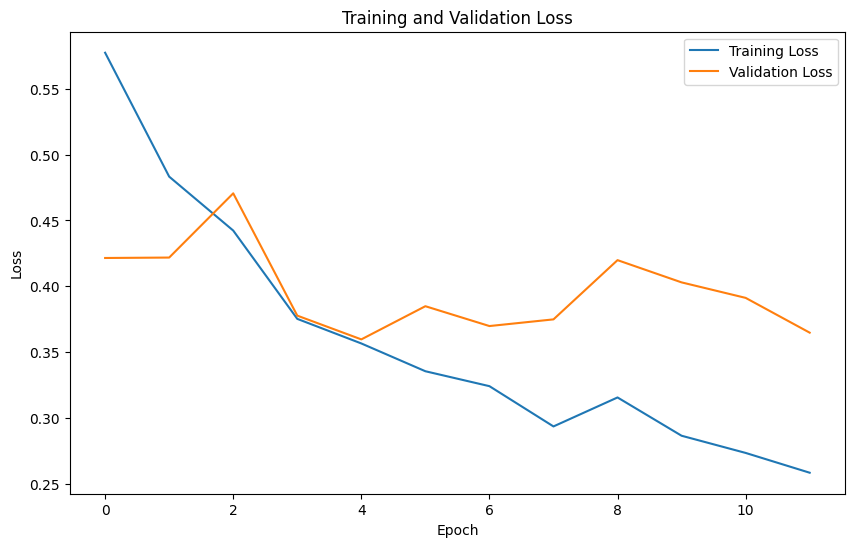

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

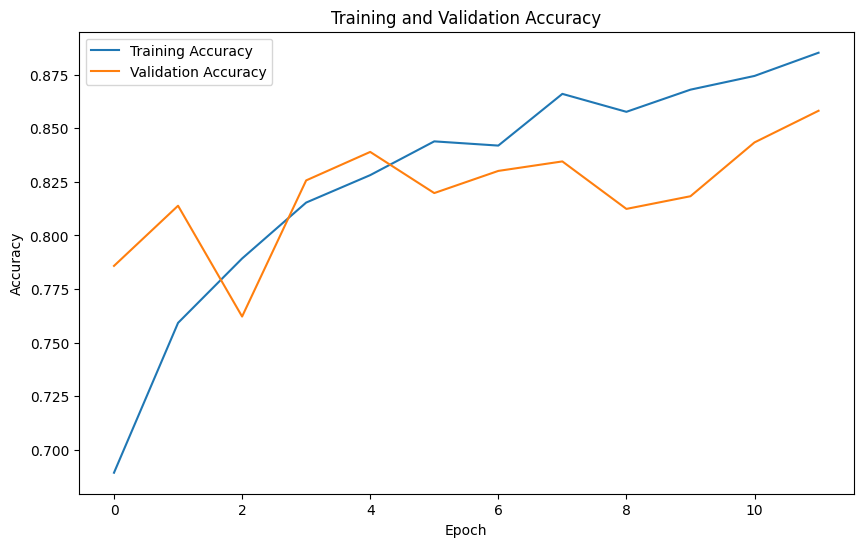

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

MODEL 2: DENSE + SELF ATTENTION

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import shutil

# Define directories and parameters
train_dir = 'train_data'
validation_dir = 'validation_data'
test_dir = 'test_data'
img_height, img_width = 331, 331  # NASNetLarge input shape
batch_size = 32
epochs = 50

# Define data generators with binary class mode
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Use binary class mode for binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure that test data is not shuffled
)

# Load NASNetLarge base model
base_model = NASNetLarge(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Added dense layer with 512 units
    layers.Dense(256, activation='relu'),  # Added dense layer with 256 units
    layers.Dense(128, activation='relu'),  # Existing dense layer with 128 units
    layers.Dropout(0.5),  # Single dropout layer
    layers.Dense(1, activation='sigmoid')  # Use sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model without class weights and with early stopping
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int32')
true_classes = test_generator.classes

# Generate classification report
print(classification_report(true_classes, predicted_classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate additional metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print train and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")


Found 2031 images belonging to 2 classes.
Found 677 images belonging to 2 classes.
Found 679 images belonging to 2 classes.
Epoch 1/50
64/64 [==============================] - 204s 3s/step - loss: 0.5607 - accuracy: 0.7031 - val_loss: 0.4286 - val_accuracy: 0.7976
Epoch 2/50
64/64 [==============================] - 181s 3s/step - loss: 0.4712 - accuracy: 0.7642 - val_loss: 0.4335 - val_accuracy: 0.7873
Epoch 3/50
64/64 [==============================] - 185s 3s/step - loss: 0.4295 - accuracy: 0.7898 - val_loss: 0.3879 - val_accuracy: 0.8035
Epoch 4/50
64/64 [==============================] - 183s 3s/step - loss: 0.3819 - accuracy: 0.8237 - val_loss: 0.5417 - val_accuracy: 0.7563
Epoch 5/50
64/64 [==============================] - 180s 3s/step - loss: 0.3455 - accuracy: 0.8439 - val_loss: 0.3676 - val_accuracy: 0.8316
Epoch 6/50
64/64 [==============================] - 184s 3s/step - loss: 0.3523 - accuracy: 0.8449 - val_loss: 0.3626 - val_accuracy: 0.8434
Epoch 7/50
64/64 [============